## Vehicle Detection
### A machine vision solution to identify and track vehicle from a dashboard camera video stream.

---

**Summary**

The solution process includes the following logic:

* Use Histogram of Oriented Gradients (HOG) to perform feature extraction on a labeled training set of images.
* Train a Linear Support Vector Machine (SVM) classifier based on the training data.
* Apply color transforms and append binned color features, color histograms, etc. to the HOG feature vector to improve performance. 
* Data is normalized, and randomized selections for training and testing data are defined.
* A sliding-window search technique is used with the trained classifier to perform a search for vehicles in the images.
* The vehicle detection pipeline is run on a video stream (first with test_video.mp4 and then later implemented on the full project_video.mp4).
* A heat map of recurring detections, frame by frame is used to reject outliers and follow detected vehicles.
* A bounding box overlay for detected vehicles is implemented.

In [1]:
# Read in packages

import os
import glob
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

import cv2

import seaborn as sns
import random
from random import shuffle

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

from tqdm import tqdm

# Using sklearn 0.191
# Valid for scikit-learn version >= 0.18
from sklearn.model_selection import train_test_split

# Valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split 

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Read in image data to lists
---

In [2]:
# Images are divided into sets of vehicles and non-vehicles folders
# Locate images

basedir = 'vehicles/'
image_types = os.listdir(basedir)

cars = []
for imtype in image_types:
    cars.extend(glob.glob(basedir + imtype + '/*'))
print('Number of Vehicle images found: ', len(cars))

with open("cars.txt", 'w') as f:
    for fn in cars:
        f.write(fn + '\n')

basedir = 'non-vehicles/'
image_types = os.listdir(basedir)

notcars = []
for imtype in image_types:
    notcars.extend(glob.glob(basedir + imtype +'/*'))

print("Number of non-Vehicle images: ", len(notcars))

with open("not_cars.txt", 'w') as f:
    for fn in notcars:
        f.write(fn + '\n')

Number of Vehicle images found:  8792
Number of non-Vehicle images:  8968


(64, 64, 3)   image shape
float32       image data type


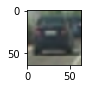

In [3]:
# Display image, check image shape, dimensions and data type

display_image = mpimg.imread(cars[0])
print(display_image.shape, '  image shape')
print(display_image.dtype, '      image data type')

plt.figure(figsize=(1,1))
plt.imshow(display_image, cmap="gray")

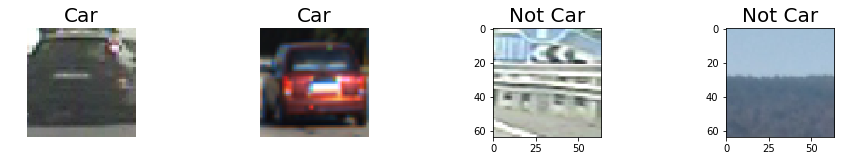

In [4]:
# Show the basic difference between Car and Not Car images in the data set

fig, axs  =  plt.subplots (1,4, figsize=(16, 2))

for i in np.arange(4):
    notcar_image = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    #axs[i].axis('off')
    axs[i].set_title('Not Car', fontsize=20)
    axs[i].imshow(notcar_image)

for i in np.arange(2):
    car_image = mpimg.imread(cars[np.random.randint(0,len(cars))])
    axs[i].axis('off')
    axs[i].set_title('Car', fontsize=20)
    axs[i].imshow(car_image)
    
    plt.savefig('output_images/data_visualization.png', 
            bbox_inches="tight")

## Define Functions for Analysis Pipeline
---
Functions taken from Object Detection class work, covering HOG, color histogram, spatial binning, etc. These will be used later in the image analysis pipeline.

### Histogram of Oriented Gradients (HOG)

In [5]:
# Define a function to return HOG features and visualization

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

### Color Histogram

In [6]:
# Define a function to compute color histogram features

def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    
    bins_range=(0, 256)
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    hist_features = np.concatenate((channel1_hist[0],
                                    channel2_hist[0],
                                    channel3_hist[0]))
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

### Spatial Binning of Color

In [7]:
# Function computes the color histogram features  
# Pass the color_space flag as 3-letter all caps string

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    
    # Return the feature vector
    return features

### Extract Features from a List of Images

In [8]:
# Function extracts features from a list of images
# Function includes calls to bin_spatial() and color_hist()

def extract_features(images, color_space='RGB', spatial_size=(32, 32), 
                     hist_bins=32, orient=9, pix_per_cell=8,
                     cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    
    # Iterate through the list of images
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file) # idea for the progress came from "nhiddink"
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)
            
        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False,
                                                feature_vec=True)
            file_features.append(hog_features)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    
    # Return list of feature vectors
    return features

### Extract Single Image Features

In [9]:
# Smilar to extract_features(), but only acts on a single image

def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    
    #1) Define an empty list to receive features
    img_features = []
    
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [10]:
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

### Compare Car vs NotCar HOG Output
---
Investigate the basic diffference between HOG output of image types to see how the HOG defines features, forming the basis for differentiating between Car and NotCar image types in the classifier.

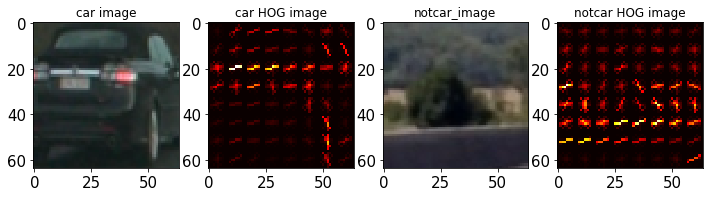

In [46]:
# Define image inputs

car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Read in the image
car_img = mpimg.imread(cars[car_ind])
car_img_gray = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)

notcar_img = mpimg.imread(notcars[notcar_ind])
notcar_img_gray = cv2.cvtColor(notcar_img, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
car_features, car_hog_image = get_hog_features(car_img_gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

notcar_features, notcar_hog_image = get_hog_features(notcar_img_gray, orient,
                                        pix_per_cell, cell_per_block,
                                        vis = True, feature_vec = False)

images_vis = [car_img, car_hog_image, notcar_img, notcar_hog_image]
titles_vis = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
fig = plt.figure(figsize = (12,3))
visualize(fig, 1, 4, images_vis, titles_vis)

plt.savefig('output_images/hog_visualization.png', 
            bbox_inches="tight")

### Train the Linear SVC Classifier

### Test Different Linear SVC Classifier Parameters

In [12]:
# Define features parameters

color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 64
spatial_feat = True
hist_feat = True
hog_feat = True

"""orient=10
pix_per_cell=8
cell_per_block=2
spatial_size=(32, 32)
hist_bins=64"""

# Define a n_sample random population for testing before processing all train data

t = time.time()
n_samples = 1000
random_idxs = np.random.randint(0, len(cars), n_samples)

#test_cars = np.array(cars)[random_idxs]
test_cars = cars
#test_notcars = np.array(notcars)[random_idxs]
test_notcars = notcars

car_features = extract_features(test_cars, color_space = color_space,
                        spatial_size = spatial_size, hist_bins = hist_bins,
                        orient = orient, pix_per_cell = pix_per_cell,
                        cell_per_block = cell_per_block,
                        hog_channel = hog_channel, spatial_feat = spatial_feat,
                        hist_feat = hist_feat, hog_feat = hog_feat)

notcar_features = extract_features(test_notcars, color_space = color_space,
                        spatial_size = spatial_size, hist_bins = hist_bins,
                        orient = orient, pix_per_cell = pix_per_cell,
                        cell_per_block = cell_per_block,
                        hog_channel = hog_channel, spatial_feat = spatial_feat,
                        hist_feat = hist_feat, hog_feat = hog_feat)

print(time.time()-t, 'Seconds to compute features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

# Labels vector

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Define train-test data split

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.1, random_state = rand_state)

# Pring out results metrics

print('Using:', orient, 'orientations', pix_per_cell,
     'pixels per cell,', cell_per_block, 'cell per block',
     hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))

#Use a linear SVC
svc = LinearSVC()

t = time.time()

svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

100%|█████████████████████████████████████████████████████████████████████████████| 8968/8968 [00:48<00:00, 186.31it/s]


95.21501350402832 Seconds to compute features...
Using: 10 orientations 8 pixels per cell, 2 cell per block 64 histogram bins, and (32, 32) spatial sampling
Feature vector length: 9144
27.55 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


### Define the Sliding Window Function

In [13]:
# Define a function that takes an image with x,y start and stop parameters,
# provides a window size (in x and y dimensions),  
# and defines an overlap fraction (for both x and y) as the window slides across the image

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), #(64, 64), (96, 96)
                 xy_overlap=(0.5, 0.5)):
    
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initialize a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    # Return the list of windows
    return window_list

In [14]:
# Define a function to draw bounding boxes

def draw_boxes(img, bboxes, color=(0,255,0), thick=3):
    
    # Make a copy of the image
    imcopy = np.copy(img)
    
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    
    # Return the image copy with boxes drawn
    return imcopy

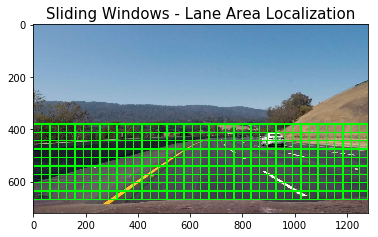

In [15]:
# To reduce computation load, only the geometric region corresponding to the road is considered
# this is defined in the y_start_stop value, and manually tuned here,
# y_start_stop = [380, 680] was taken as the ideal window,
# covering the region from the top of the hood of the car to the horizon of the road

test_img = mpimg.imread('test_images/test3.jpg')

windows =  slide_window(test_img,
                        x_start_stop = [None, None],
                        y_start_stop = [380, 680],
                        xy_window=(64, 64),
                        xy_overlap=(0.5, 0.5))

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows - Lane Area Localization', fontsize=15);
plt.savefig('output_images/sliding_windows_vis001.png', bbox_inches="tight")

### Define the Search Windows Function

In [16]:
# Using the output of slide_windows(), search_windows()
# will search the windows and predict with the trained classifier
# found windows will be appended to a defined list

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    #2) Iterate over all windows in the list
    for window in windows:
        
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)

    #8) Return windows for positive detections
    return on_windows

### Test the slide_window() and search_windows() functions

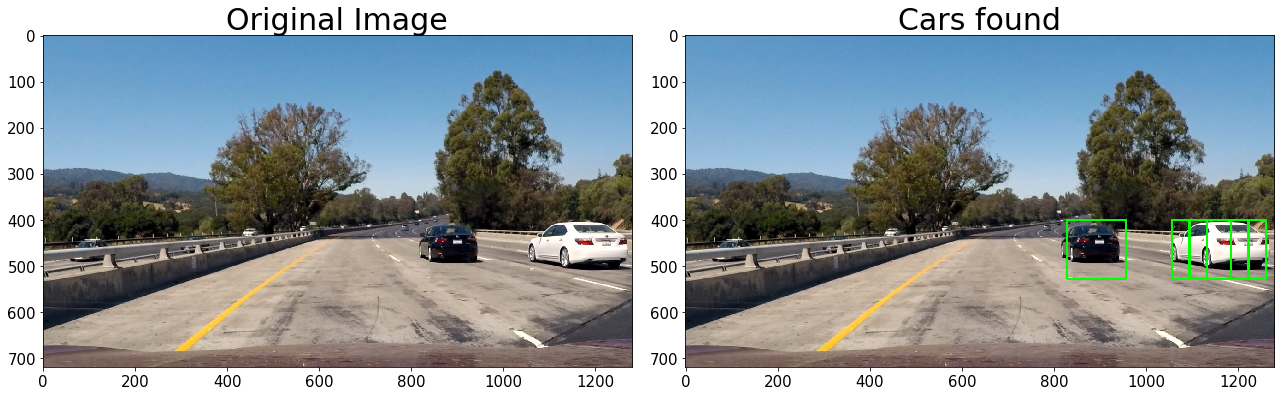

In [19]:
fname = 'test_images/test{}.jpg'.format(i)
image = mpimg.imread(fname)
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
    
image = image.astype(np.float32)/255

windows =  slide_window(test_img,
                            x_start_stop=[600, None],
                            y_start_stop=[400, 656], #tune the parameters
                            xy_window=(128,128),
                            xy_overlap=(.7,.7))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows) 
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
plt.tight_layout()
ax1.imshow(draw_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(window_img)
ax2.set_title('Cars found', fontsize=30)

plt.savefig('output_images/windows.png', bbox_inches="tight")

### Run the Search Windows Function on Test Images

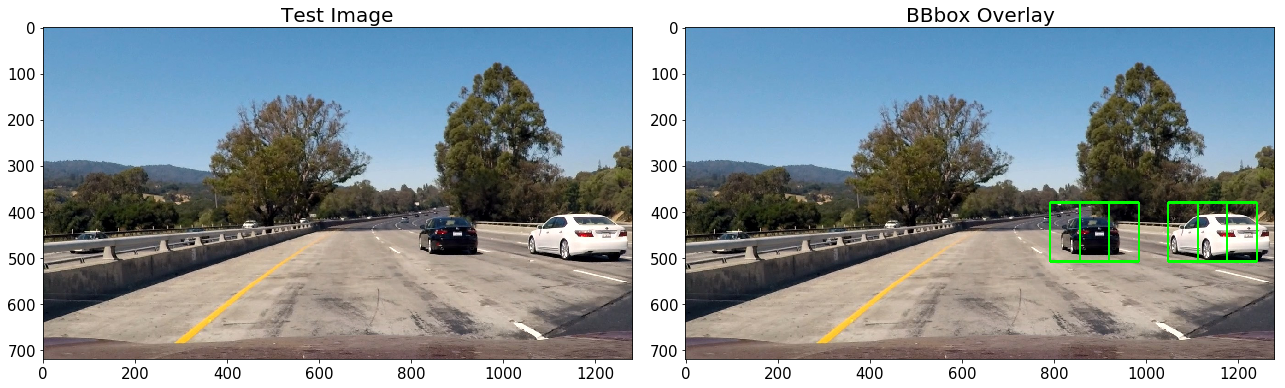

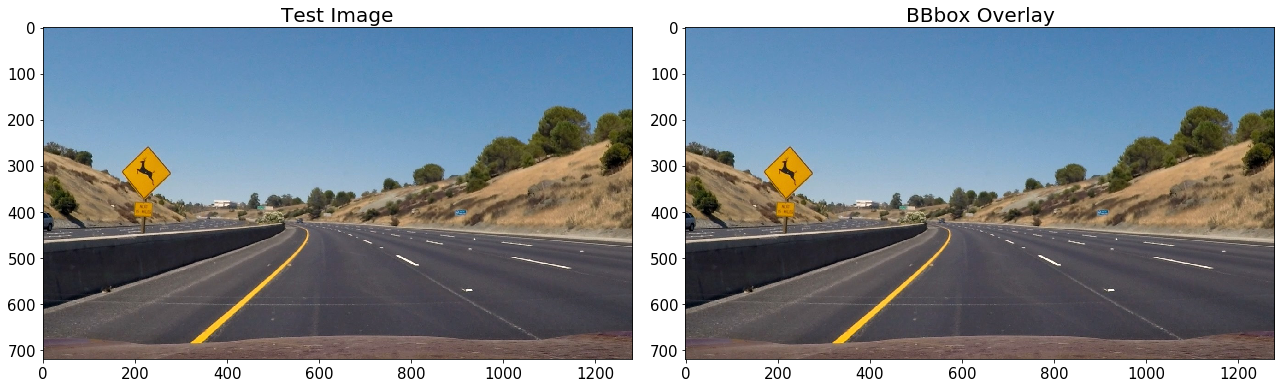

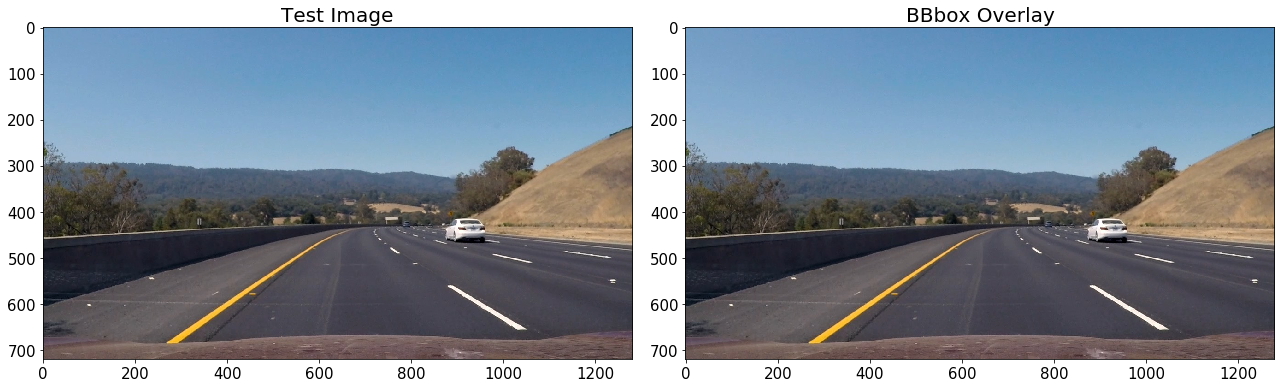

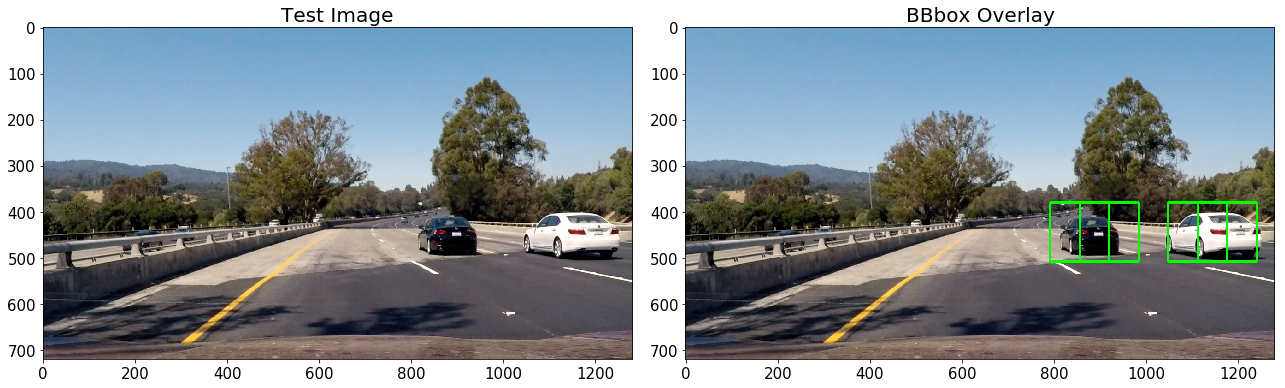

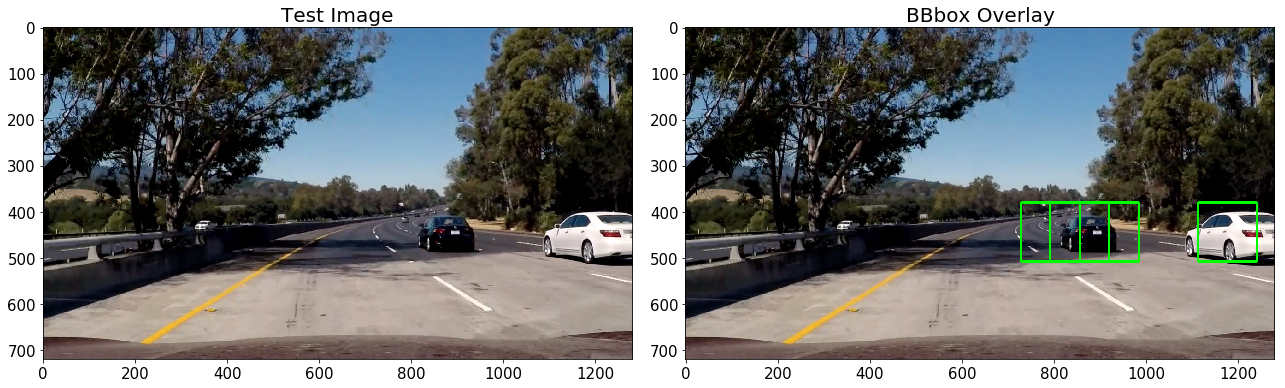

In [20]:
# Read in images from the test_images folder and test the slide_window() and search_windows() functions.

for i in range(1,6):
    
    fname = 'test_images/test{}.jpg'.format(i)
    image = mpimg.imread(fname)
    draw_image = np.copy(image)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    
    image = image.astype(np.float32)/255

    windows =  slide_window(test_img,
                            x_start_stop=[600, None],
                            y_start_stop=[380, 680],
                            xy_window=(128,128),
                            xy_overlap=(.5,.5))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows) 
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(draw_image)
    ax1.set_title('Test Image', fontsize=20)
    ax2.imshow(window_img)
    ax2.set_title('BBbox Overlay', fontsize=20)
    plt.savefig('output_images/test_image_bbox.png', bbox_inches="tight")

### Apply Heat Map and Threshold
---
A heat map is defined on the output of the search_windows() function, a threshold is included, which will aid in finding cars versus mis-classified areas of the environment. The heat map is applied to areas found in the bounding box list.


In [21]:
# Define functions for addeing heat map, associated threshold and color conversions.

def add_heat(heatmap, bbox_list):
    
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 8)
    
    # Return the image
    return img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

### Define the find_cars() Function
---
Main function which combines feature extraction and prediction.

In [22]:
# Define function that can extract features using hog sub-sampling and make predictions

def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,
                                     (np.int(imshape[1]/scale),
                                      np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[]
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart),
                              (255,0,0),8)
                bbox_list.append(((xbox_left, ytop_draw+ystart), #github.com/preritj
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    
    return bbox_list

### Final Parameter Tuning
---
The search and classification method is investigated with heat map derviation from the bounding box output, evaluation on test images list, and investigate how well the method is working to find cars using the find_cars() function.

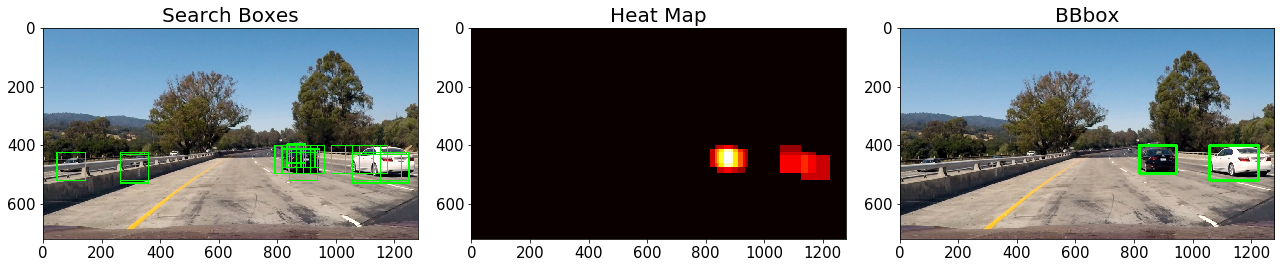

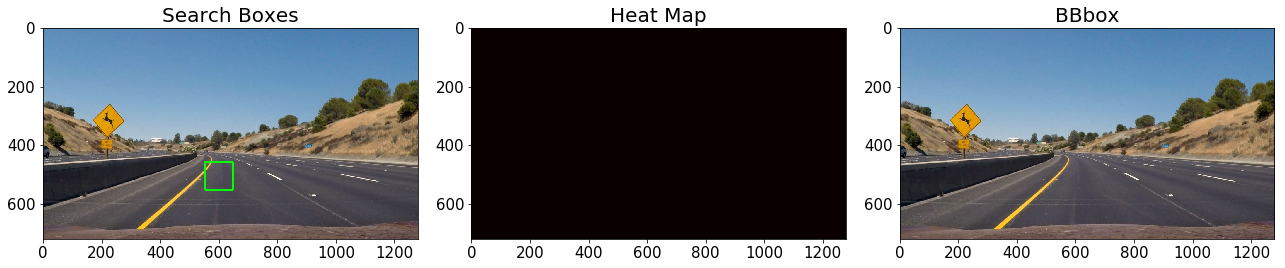

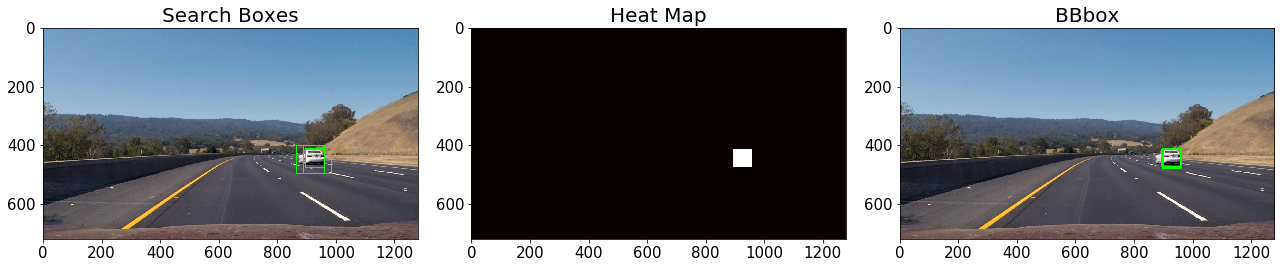

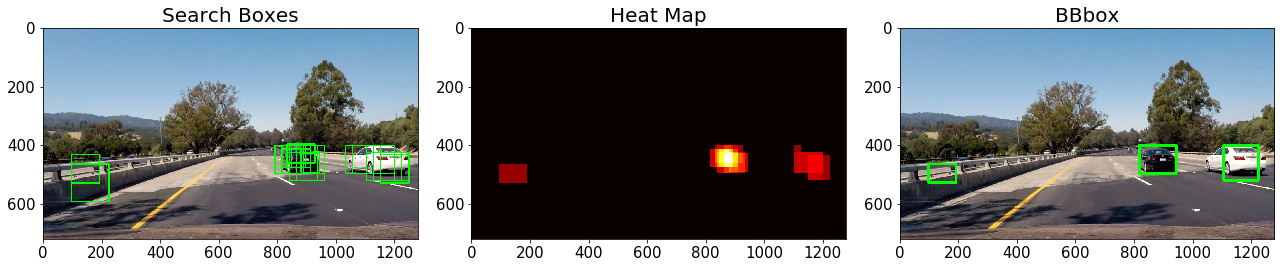

In [27]:
# Define parameters for sliding window searches,
# modify the (ystart, ystop) parameters of the find_cars() function,
# modify scale parameter from minimum 1.0 to 2.0
# (ystart, ystop) previously defined at (380, 680)


for i in range(1,6):
    
    fname = 'test_images/test{}.jpg'.format(i)
    img = mpimg.imread(fname)
    
    # Define parameters to agree with the classifier training,
    # otherwise shpae mismatches will exist
    
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 412
    ystop = 582
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 432
    ystop = 632
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 464
    ystop = 664
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    ystart = 464
    ystop = 664
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    out_img = draw_boxes(img, bbox_list)
    
    # Apply heatmap and threshold
    # Heatmap threshold investigated from 1 to 3,
    # best performance seen with threshold = 2
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,9))
    plt.tight_layout()
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes', fontsize=20)
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map', fontsize=20)
    ax3.imshow(new_img)
    ax3.set_title('BBbox', fontsize=20)
    plt.savefig('output_images/find_cars_heat_map_optimization.png')

### Image Processing Function
---
The final process_image() function is defined with the correct parameters and slide window approach to identify cars using the find_cars() function for each sliding set.

In [24]:
# Define final image processing funciton

def process_image(img):

    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    bbox_list = []
    
    ystart = 380
    ystop = 550
    scale = 1.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 464
    ystop = 664
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 2)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

In [25]:
test_output = "output_videos/test_output.mp4"
clip = VideoFileClip("test_video.mp4")
test_clip = clip.fl_image(process_image)
%time test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_videos/test_output.mp4
[MoviePy] Writing video output_videos/test_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:35<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_output.mp4 

Wall time: 35.9 s


In [26]:
output  =  "output_videos/project_video.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:11<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 19min 12s
